In [42]:
%matplotlib inline

import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.datasets import load_breast_cancer, load_boston

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import preprocessing
from sklearn import utils


import statsmodels.api as sm

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import itertools


In [43]:
d = pd.read_csv('data/normalized_temp_data_together.csv')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)
df = df.set_index(pd.DatetimeIndex(df.DateTime))
df.head()

,Unnamed: 0,DateTime,Henry Hub Price $/MMBtu,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,Temp
DateTime,,,,,,,,,
2010-01-01,0,2010-01-01,5.82,2197157.0,3117.0,255035.0,1666520.0,1,33.150210
2010-01-02,1,2010-01-02,5.82,2197157.0,3117.0,255035.0,1666520.0,2,28.389823
2010-01-03,2,2010-01-03,5.82,2197157.0,3117.0,255035.0,1666520.0,3,26.753999
2010-01-04,3,2010-01-04,6.09,2197157.0,3117.0,255035.0,1666520.0,4,27.523758
2010-01-05,4,2010-01-05,6.19,2197157.0,3117.0,255035.0,1666520.0,5,28.425495


In [3]:
df['MOY'] =df['DateTime']
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

df['WOY'] =df['DateTime']
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))
df['WOY'] = df['WOY'].apply(lambda x : woy(x))

In [4]:
df['consump_trend'] = sm.tsa.seasonal_decompose(df['Consumption MMCF'], freq= 365).trend.fillna(method= 'backfill').fillna(method= 'ffill')

In [5]:
doy = df.pop('DOY')

In [6]:
df.head(2)

,Unnamed: 0,DateTime,Henry Hub Price $/MMBtu,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,Temp,MOY,WOY,consump_trend
DateTime,,,,,,,,,,,
2010-01-01,0,2010-01-01,5.82,2197157.0,3117.0,255035.0,1666520.0,33.150210,1,53,1.974475e+06
2010-01-02,1,2010-01-02,5.82,2197157.0,3117.0,255035.0,1666520.0,28.389823,1,53,1.974475e+06


In [7]:
dfw =df.resample('W').mean()

In [8]:
dfw.head(2)

,Unnamed: 0,Henry Hub Price $/MMBtu,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,Temp,MOY,WOY,consump_trend
DateTime,,,,,,,,,,
2010-01-03,1.0,5.820000,2197157.0,3117.0,255035.0,1666520.0,29.431344,1.0,53.0,1.974475e+06
2010-01-10,6.0,6.562857,2197157.0,3117.0,255035.0,1666520.0,27.893440,1.0,1.0,1.974475e+06


In [9]:
dfw['one_week_back_temp'] = dfw['Temp'].shift(1).fillna(method= 'backfill')
dfw['two_week_back_temp'] = dfw['Temp'].shift(2).fillna(method= 'backfill')

In [10]:
dfw.columns

Index(['Unnamed: 0', 'Henry Hub Price $/MMBtu', 'Production MMCF',
       'Storage BCFE', 'Reserves BCFE', 'Consumption MMCF', 'Temp', 'MOY',
       'WOY', 'consump_trend', 'one_week_back_temp', 'two_week_back_temp'],
      dtype='object')

In [12]:
matrix = ['Consumption MMCF', 'Temp', 'Production MMCF', 'Storage BCFE',
       'MOY', 'WOY', 'consump_trend',
       'one_week_back_temp', 'two_week_back_temp']

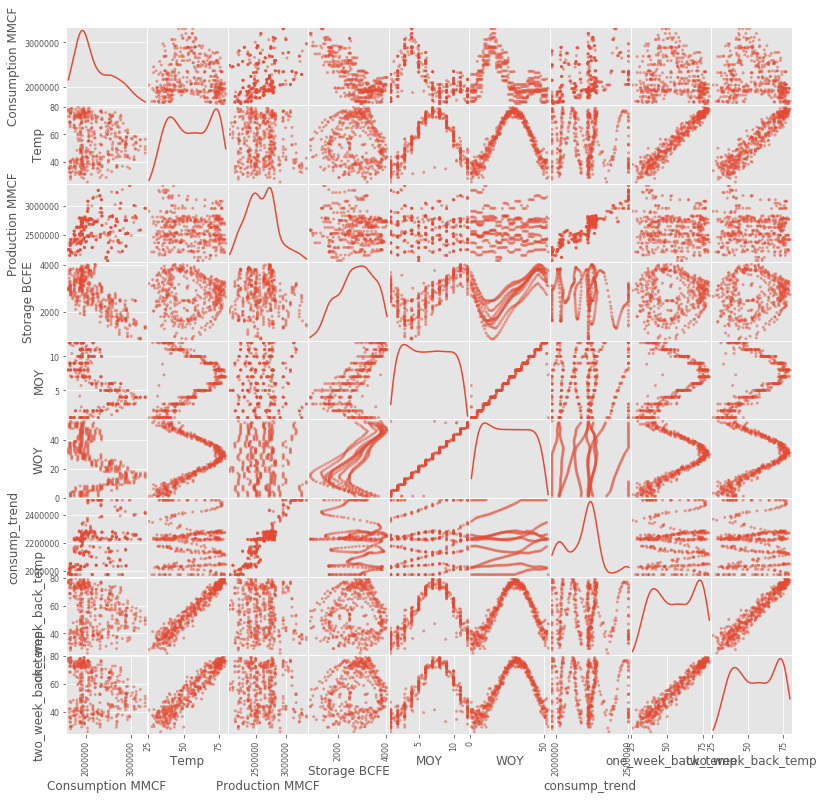

In [13]:
from pandas.plotting import scatter_matrix
fig, ax = plt.subplots(1, 1, figsize=(13, 13))
ax = scatter_matrix(dfw[matrix], ax=ax, diagonal='kde')

In [18]:
fil = ['Temp', 'Production MMCF', 'Storage BCFE',
       'MOY', 'WOY', 'consump_trend',
       'one_week_back_temp', 'two_week_back_temp']

In [19]:
y = dfw.pop('Consumption MMCF').values

In [20]:
X = dfw[fil].values

In [21]:
size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X[0:size], X[size:len(X)], y[0:size], y[size:len(y)]

In [24]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,8)))
    yhat = output[0]
    predictions.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))

error = mean_squared_error(y_test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 33866727913.86791


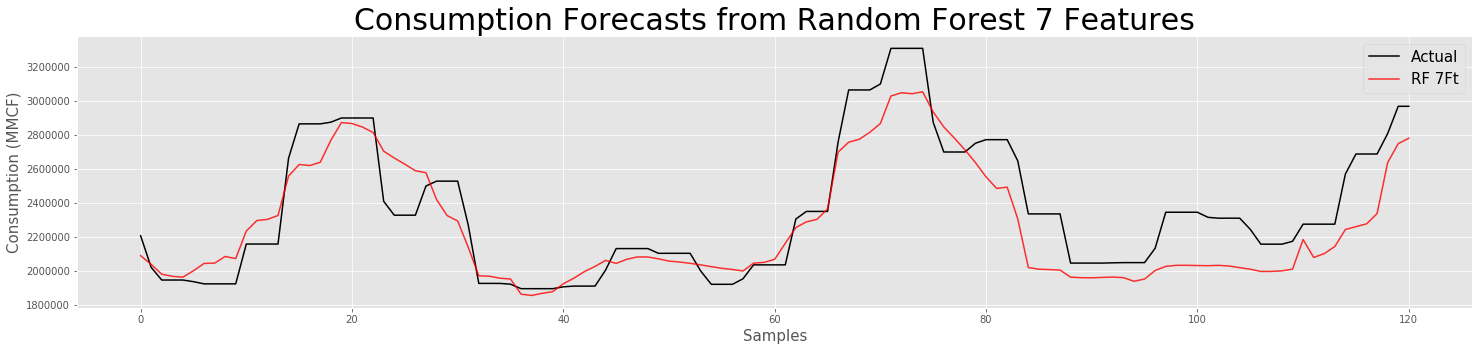

In [25]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black', label = 'Actual')
axs.plot(predictions, color='red', alpha = 0.8, label = 'RF 7Ft')
axs.set_title("Consumption Forecasts from Random Forest 7 Features", fontsize = 30)
axs.set_ylabel("Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Samples", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

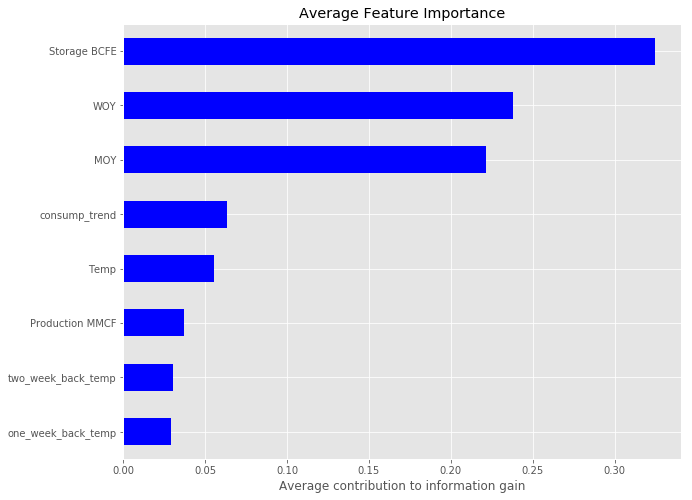

In [26]:
# Plot the feature importance
feat_scores = pd.Series(rfr.feature_importances_,
                           index=dfw[fil].columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Feature Importance')
ax.set_xlabel('Average contribution to information gain');

In [27]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions2 = list()
grd = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=2,
             max_leaf_nodes=2, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=5000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
grd_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = grd_fit.predict(X_test[t].reshape((1,8)))
    yhat = output[0]
    predictions2.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))

error = mean_squared_error(y_test, predictions2)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 33823493199.35303


Bentchmark from total avg temp Test MSE: 42818641408.66167

~1.4% improvement (7 hours of work) 

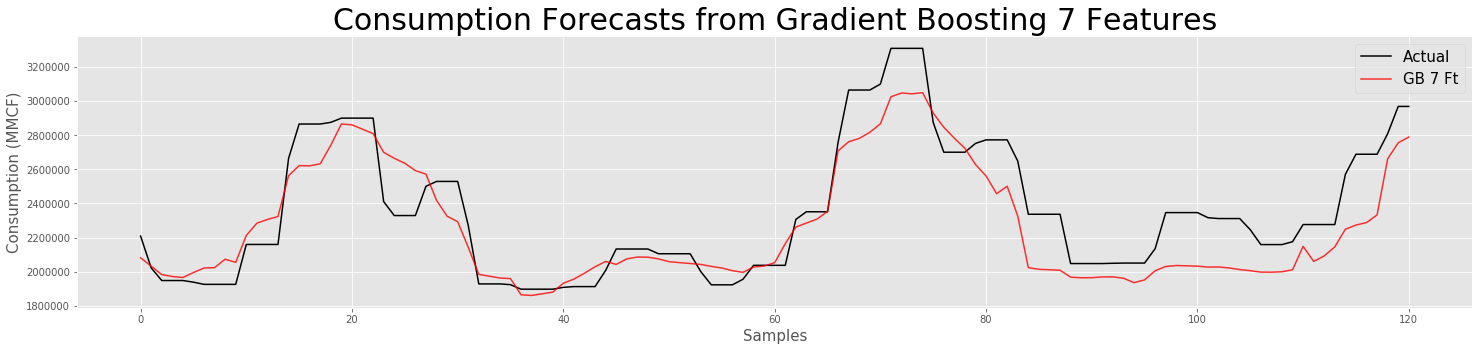

In [29]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black', label = 'Actual')
#axs.plot(y_train, color='blue')
axs.plot(predictions2, color='red', alpha = 0.8, label = 'GB 7 Ft')
axs.set_title("Consumption Forecasts from Gradient Boosting 7 Features", fontsize = 30)
axs.set_ylabel("Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Samples", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

In [32]:
fil2 = ['Temp', 'Production MMCF', 'Storage BCFE',
       'MOY', 'WOY', 'consump_trend']

In [33]:
X2 = dfw[fil2].values

In [34]:
size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X2[0:size], X2[size:len(X)], y[0:size], y[size:len(y)]

In [36]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions3 = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,6)))
    yhat = output[0]
    predictions3.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))

error = mean_squared_error(y_test, predictions3)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 32287048224.06265


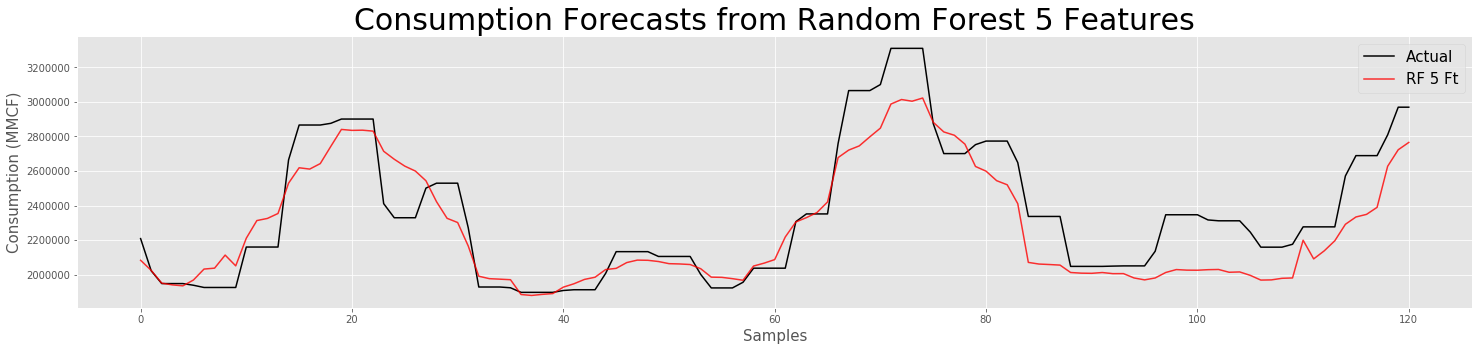

In [37]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black', label = 'Actual')
axs.plot(predictions3, color='red', alpha = 0.8, label = 'RF 5 Ft')
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
axs.set_title("Consumption Forecasts from Random Forest 5 Features", fontsize = 30)
axs.set_ylabel("Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Samples", fontsize = 15)
axs.legend(fontsize = 15)
plt.show()

In [41]:
len(y_train)

360

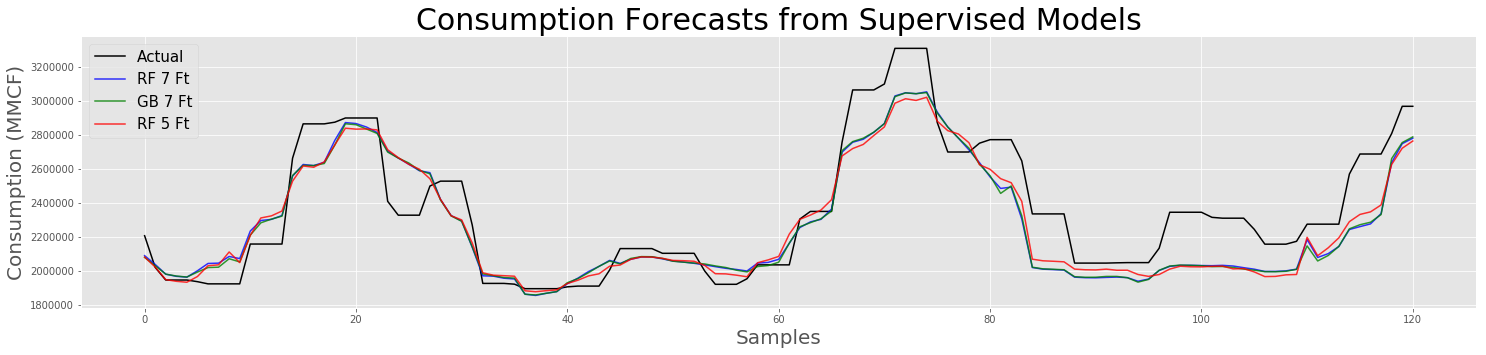

In [38]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black', label = 'Actual')
axs.plot(predictions, color='blue', alpha = 0.8, label = 'RF 7 Ft')
axs.plot(predictions2, color='green', alpha = 0.8, label = 'GB 7 Ft')
axs.plot(predictions3, color='red', alpha = 0.8, label = 'RF 5 Ft')
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
axs.set_title("Consumption Forecasts from Supervised Models", fontsize = 30)
axs.set_ylabel("Consumption (MMCF)", fontsize = 20)
axs.set_xlabel("Samples", fontsize = 20)
axs.legend(fontsize = 15)
plt.show()


No handles with labels found to put in legend.


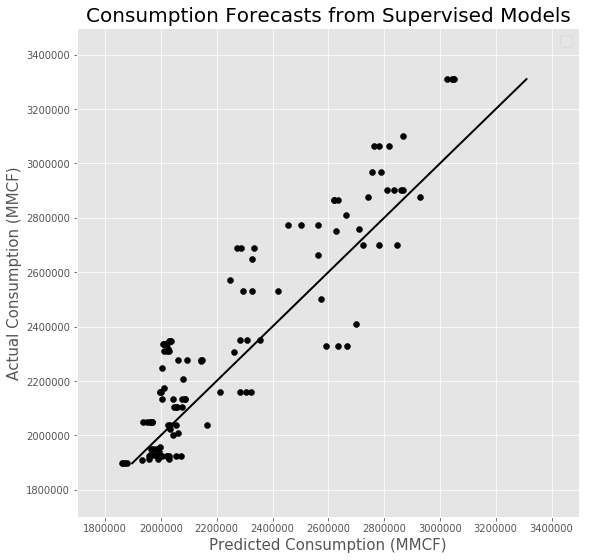

In [39]:
fig, axs = plt.subplots(figsize=(9, 9))
axs.scatter(predictions2,y_test, color='black')

axs.plot([min(y_test), max(y_test)-2], 
          [min(y_test), max(y_test) -2], 'k', lw=2)

axs.set_xlim([1700000, 3500000])
axs.set_ylim([1700000, 3500000])
axs.set_title("Consumption Forecasts from Supervised Models", fontsize = 20)
axs.set_ylabel("Actual Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Predicted Consumption (MMCF)", fontsize = 15)
axs.legend(fontsize = 15)
plt.show()

## In general, the best model is under predicting.